You should consider upgrading via the '/Users/mac/Documents/UR_RAG_Code/venv/bin/python3 -m pip install --upgrade pip' command.


Device set to use mps:0
INFO:__main__:Loading LangChain MultiVector results from langchain_multivector_complete_results.csv
INFO:__main__:Initializing RAG Evaluator with model: intfloat/multilingual-e5-large
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
INFO:__main__:Evaluating query 1/899: 3 اپریل کو اولمپک مشعل کس شہر میں تھی؟...
Batches: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
INFO:__main__:Evaluating query 2/899: چینی حکومت نے بائیکاٹ کی صورتحال کو کم کرنے کے لئے...
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
INFO:__main__:Evaluating query 3/899: 2008 کے اولمپکس کے لئے پہلے مشعل بردار کا نام کیا ...
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
INFO:__main__:Evaluating query 4/899: کون سی حکومت مشعل کے راستے کی وضاحت کرنے کے لئے اس...
Batches: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
INFO:__main__:Evaluating query 5/899: قازقستان میں روٹ کے لئے کلومیٹر میں فاصلہ کیا تھا؟...
Batches: 


📊 Average Metrics for LangChain MultiVector Retriever
------------------------------------------------------------
Faithfulness             : 0.848
Answer Relevancy         : 0.896
Context Recall           : 0.004
Context Precision        : 0.001
Entity Recall            : 0.045


,faithfulness,answer_relevancy,context_recall,context_precision,entity_recall
0,0.848022,0.896142,0.004449,0.001001,0.045351


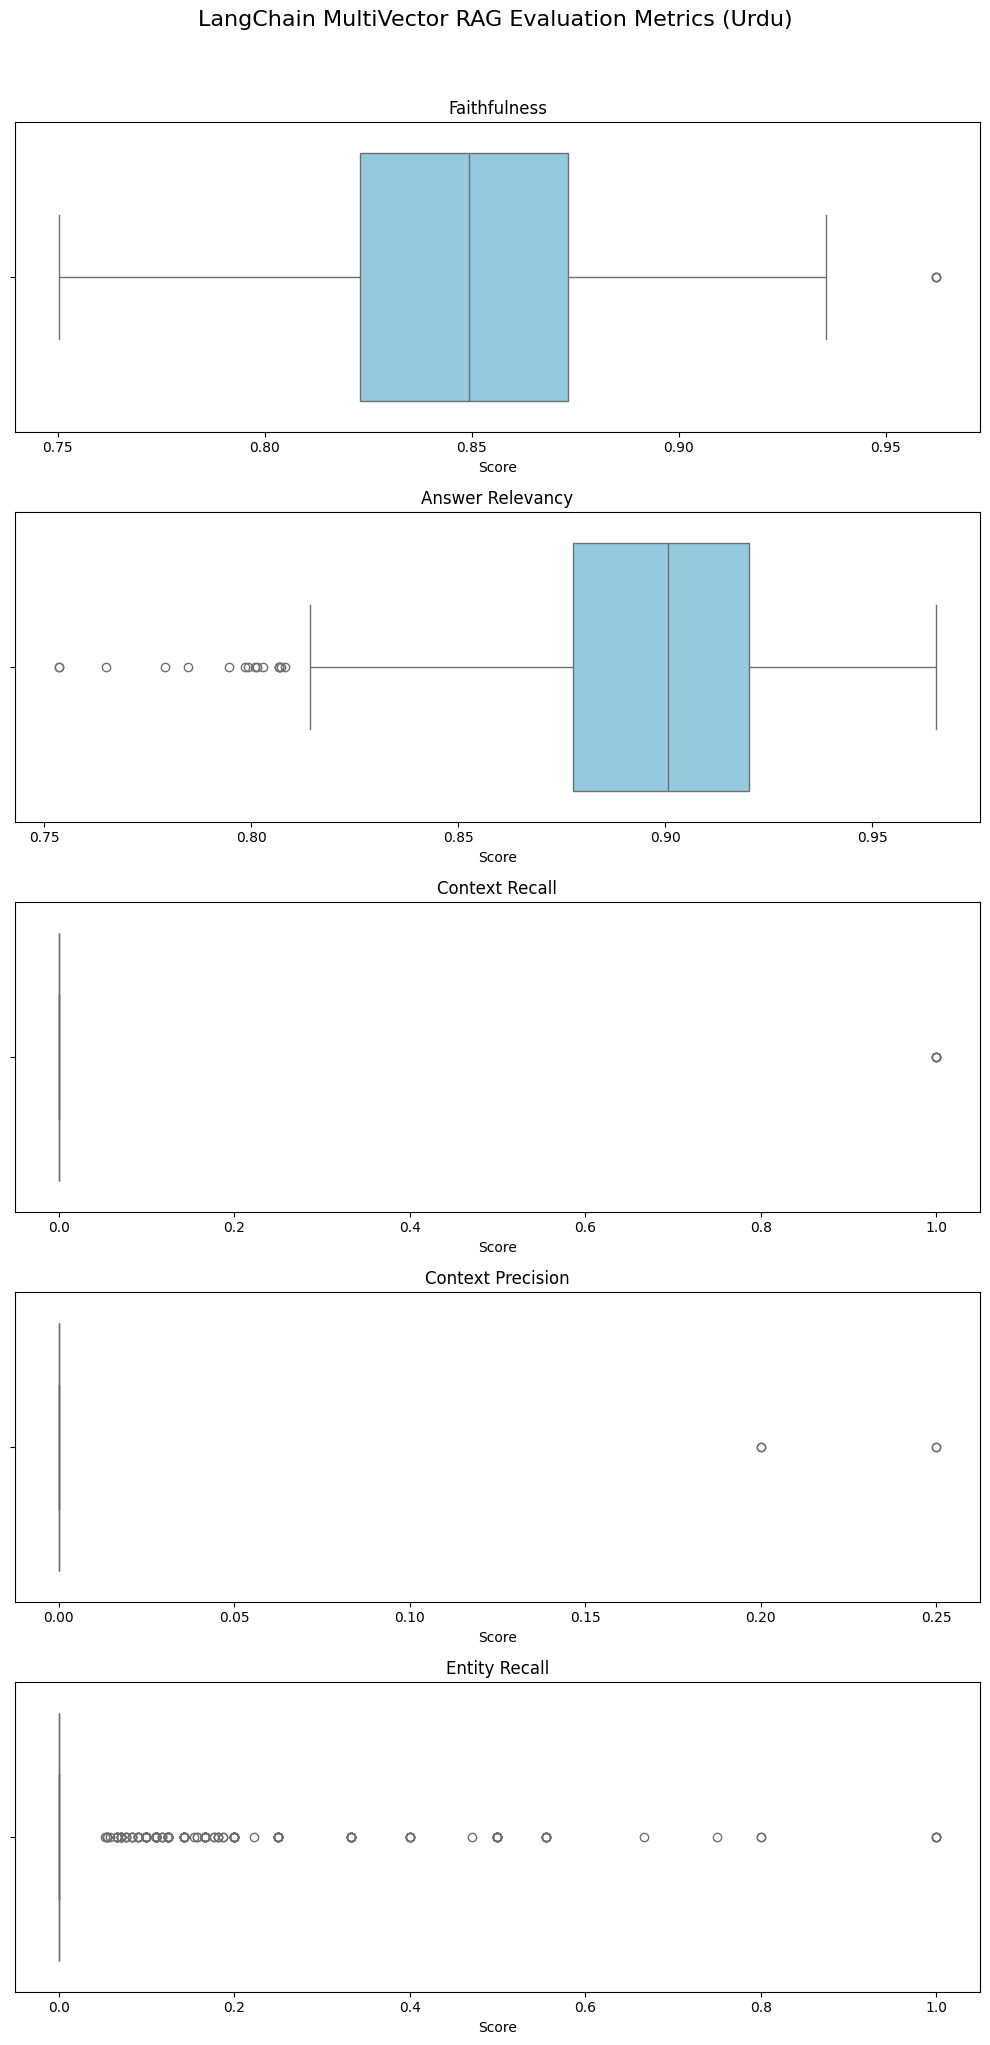

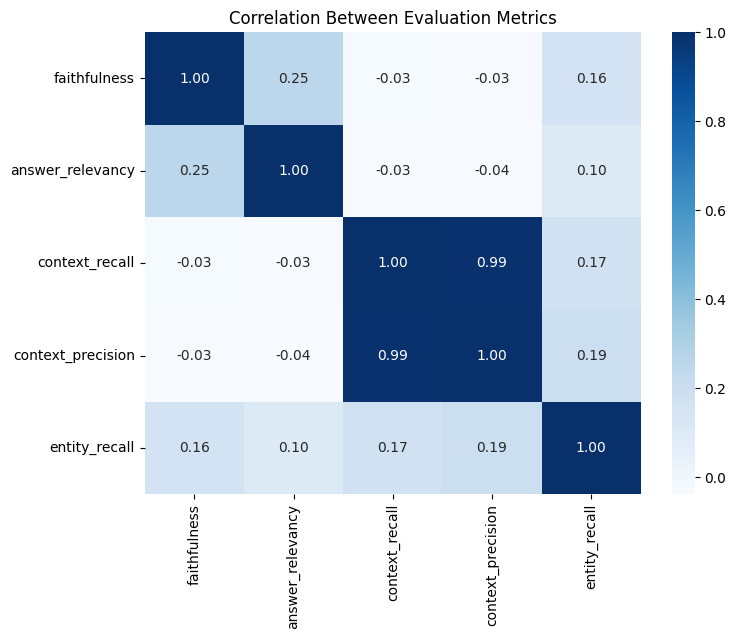

✅ Saved evaluation results to LangChain_MultiVector_Evaluation_Urdu.csv


In [5]:
# =============================================
# LangChain MultiVector Retriever Evaluation (Urdu)
# =============================================

!pip install -q numpy pandas matplotlib seaborn sentence-transformers scikit-learn stanza ipython transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict
from IPython.display import display
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# ---------------------------------------------
# Setup logging
# ---------------------------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---------------------------------------------
# Urdu NER model setup (mirfan899/urdu-bert-ner)
# ---------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("mirfan899/urdu-bert-ner")
model = AutoModelForTokenClassification.from_pretrained("mirfan899/urdu-bert-ner")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# =============================================
# RAG Evaluator Class
# =============================================
class RAGEvaluator:
    def __init__(self, sentence_transformer: str = 'intfloat/multilingual-e5-large'):
        logger.info(f"Initializing RAG Evaluator with model: {sentence_transformer}")
        self.model = SentenceTransformer(sentence_transformer, device='cuda' if torch.cuda.is_available() else 'cpu')

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        vec1 = vec1 / (np.linalg.norm(vec1) + 1e-12)
        vec2 = vec2 / (np.linalg.norm(vec2) + 1e-12)
        return float(np.dot(vec1, vec2))

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        """Semantic alignment of generated answer with retrieved context."""
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        """Semantic relevance of answer to query."""
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def extract_entities(self, text: str) -> set:
        """Extract named entities using Urdu-BERT NER model."""
        try:
            ner_results = ner_pipeline(text)
            entities = {ent['word'].strip() for ent in ner_results if ent['score'] > 0.6}
            return entities
        except Exception as e:
            logger.error(f"NER extraction error: {str(e)}")
            return set()

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        """Compute recall & precision between entities in query and context."""
        query_entities = self.extract_entities(query)
        context_entities = self.extract_entities(context)

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        intersection = query_entities.intersection(context_entities)
        recall = len(intersection) / len(query_entities)
        precision = len(intersection) / len(context_entities) if context_entities else 0.0
        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth_context: str) -> float:
        """Entity-level recall between retrieved and gold context."""
        retrieved_entities = self.extract_entities(retrieved_context)
        truth_entities = self.extract_entities(ground_truth_context)
        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str, generated_answer: str, ground_truth_context: str) -> Dict[str, float]:
        """Compute all metrics for a single sample."""
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)
            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth_context)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return dict.fromkeys(
                ["faithfulness", "answer_relevancy", "context_recall", "context_precision", "entity_recall"], 0.0
            )

# =============================================
# Plot Functions
# =============================================
def plot_metric_distribution(results_df: pd.DataFrame):
    """Boxplots for each metric."""
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4 * len(metrics)))
    fig.suptitle('LangChain MultiVector RAG Evaluation Metrics (Urdu)', y=1.02, fontsize=16)

    for ax, metric in zip(axes, metrics):
        sns.boxplot(x=results_df[metric], ax=ax, color='skyblue')
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel('Score')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(results_df: pd.DataFrame):
    """Show correlations among metrics."""
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    plt.figure(figsize=(8, 6))
    sns.heatmap(results_df[metrics].corr(), annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Between Evaluation Metrics")
    plt.show()

# =============================================
# Evaluation Function
# =============================================
def evaluate_langchain_multivector(input_csv: str) -> pd.DataFrame:
    """
    Evaluate LangChain MultiVector Retriever results CSV.
    Expected columns: ['question', 'context', 'langchain_retrieved_context', 'langchain_refined_answer']
    """
    logger.info(f"Loading LangChain MultiVector results from {input_csv}")
    df = pd.read_csv(input_csv)

    required_cols = ['question', 'context', 'langchain_retrieved_context', 'langchain_refined_answer']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    evaluator = RAGEvaluator()
    results = []

    for idx, row in df.iterrows():
        query = str(row['question'])
        retrieved_context = str(row['langchain_retrieved_context'])
        generated_answer = str(row['langchain_refined_answer'])
        ground_truth_context = str(row['context'])

        logger.info(f"Evaluating query {idx + 1}/{len(df)}: {query[:50]}...")
        metrics = evaluator.evaluate_approach(query, retrieved_context, generated_answer, ground_truth_context)

        results.append({
            'question': query,
            'faithfulness': metrics['faithfulness'],
            'answer_relevancy': metrics['answer_relevancy'],
            'context_recall': metrics['context_recall'],
            'context_precision': metrics['context_precision'],
            'entity_recall': metrics['entity_recall']
        })

    results_df = pd.DataFrame(results)
    logger.info("✅ Evaluation completed successfully.")

    # Summary
    print("\n📊 Average Metrics for LangChain MultiVector Retriever")
    print("-" * 60)
    summary = {metric: results_df[metric].mean() for metric in results_df.columns if metric != 'question'}
    for metric, val in summary.items():
        print(f"{metric.replace('_', ' ').title():25s}: {val:.3f}")

    # Display summary DataFrame
    summary_df = pd.DataFrame([summary])
    display(summary_df)

    # Visualizations
    plot_metric_distribution(results_df)
    plot_correlation_heatmap(results_df)

    return results_df

# =============================================
# Run Evaluation
# =============================================
input_csv = "langchain_multivector_complete_results.csv"  # <-- your generated results
results_df = evaluate_langchain_multivector(input_csv)

# Save results
results_df.to_csv("RAGAS_Evaluation_MultiVector.csv", index=False, encoding="utf-8-sig")
print("✅ Saved evaluation results to LangChain_MultiVector_Evaluation_Urdu.csv")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.1 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.0.2 which is incompatible.
tf-keras 2.20.1 requires tensorflow<2.21,>=2.20, but you have tensorflow 2.15.1 which is incompatible.
urduhack 1.1.1 requires Click~=7.1, but you have click 8.1.8 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 280.8 kB/s  0:00:460:00:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


INFO:__main__:Loading LangChain MultiVector results from langchain_multivector_english_results.csv
INFO:__main__:Initializing RAG Evaluator with model: sentence-transformers/all-mpnet-base-v2
INFO:datasets:TensorFlow version 2.15.1 available.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:__main__:Evaluating query 1/1205: When did the tradition of people carrying the Olym...
Batches: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]
INFO:__main__:Evaluating query 2/1205: How many days did people carry the Olympic torch b...
Batches: 100%|██████████| 1/1 [00:00<00:00, 72.60it/s]
INFO:__main__:Evaluating query 3/1205: What was the theme for the torch relay?...
Batches: 100%|██████████| 1/1 [00:00<00:00, 39.39it/s]
INFO:__main__:Evaluating query 4/1205: What did the organizers of the torch relay call it...
Batches: 100%|██████████| 1/1 [


📊 Average Metrics for LangChain MultiVector Retriever (English)
------------------------------------------------------------
Faithfulness             : 0.557
Answer Relevancy         : 0.715
Context Recall           : 0.334
Context Precision        : 0.071
Entity Recall            : 0.275


,faithfulness,answer_relevancy,context_recall,context_precision,entity_recall
0,0.55684,0.714676,0.334346,0.071012,0.27542


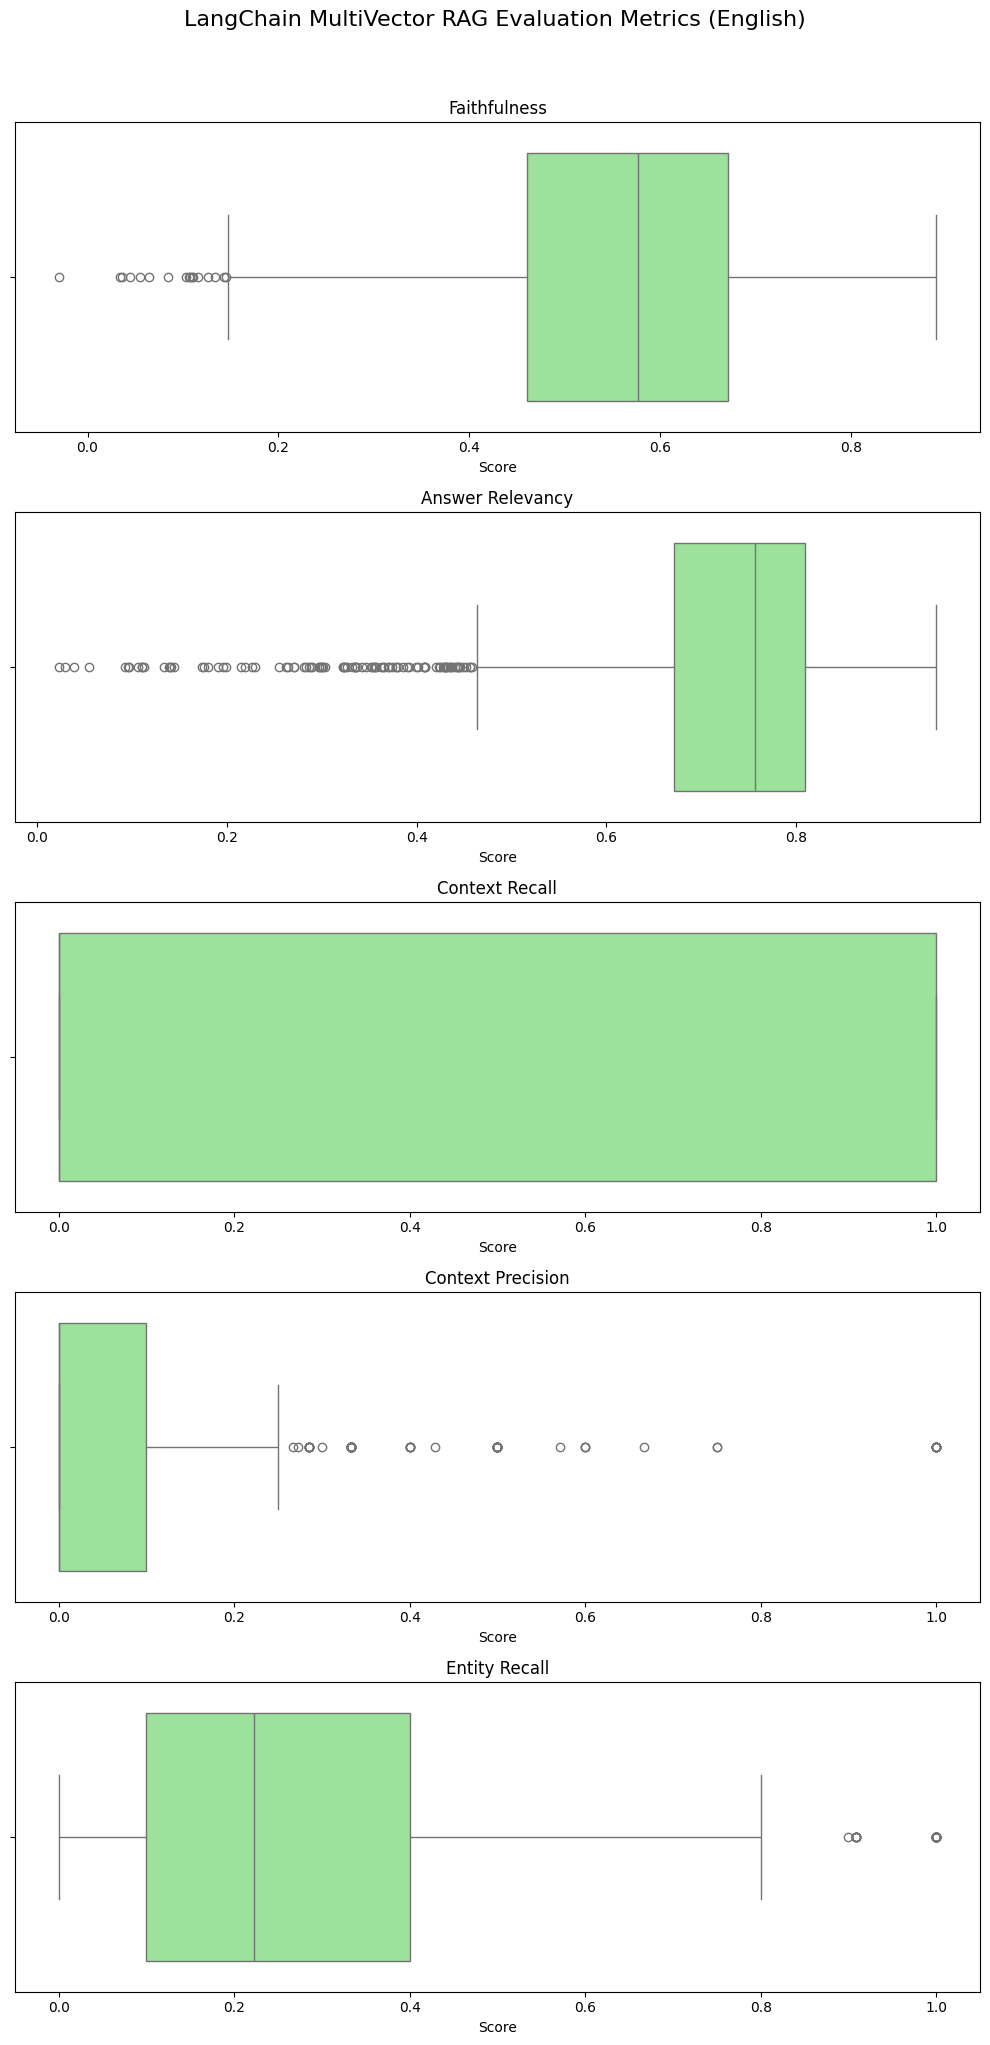

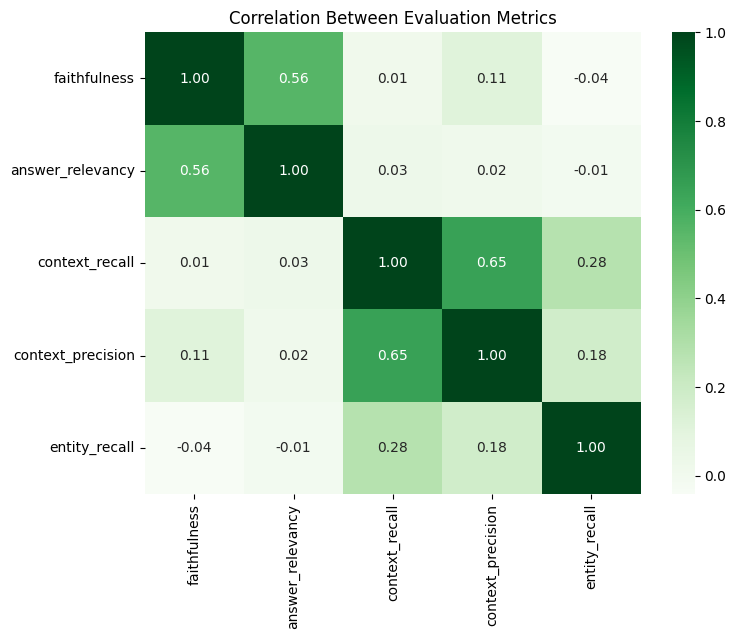

✅ Saved evaluation results to LangChain_MultiVector_Evaluation_English.csv


In [6]:
# =============================================
# LangChain MultiVector Retriever Evaluation (English)
# =============================================

!pip install -q numpy pandas matplotlib seaborn sentence-transformers scikit-learn spacy ipython transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict
from IPython.display import display
import spacy

# ---------------------------------------------
# Setup logging
# ---------------------------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---------------------------------------------
# English NER model setup (spaCy)
# ---------------------------------------------
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# =============================================
# RAG Evaluator Class (English)
# =============================================
class RAGEvaluator:
    def __init__(self, sentence_transformer: str = 'sentence-transformers/all-mpnet-base-v2'):
        logger.info(f"Initializing RAG Evaluator with model: {sentence_transformer}")
        self.model = SentenceTransformer(sentence_transformer)

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return float(cosine_similarity([vec1], [vec2])[0][0])

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        """How well the answer aligns with retrieved context."""
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        """How relevant the answer is to the original question."""
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def extract_entities(self, text: str) -> set:
        """Extract named entities using spaCy NER for English."""
        try:
            doc = nlp(text)
            entities = {ent.text.strip().lower() for ent in doc.ents}
            return entities
        except Exception as e:
            logger.error(f"NER extraction error: {str(e)}")
            return set()

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        """Compute recall & precision between entities in query and context."""
        query_entities = self.extract_entities(query)
        context_entities = self.extract_entities(context)

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        intersection = query_entities.intersection(context_entities)
        recall = len(intersection) / len(query_entities)
        precision = len(intersection) / len(context_entities) if context_entities else 0.0
        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth_context: str) -> float:
        """Entity-level recall between retrieved and gold context."""
        retrieved_entities = self.extract_entities(retrieved_context)
        truth_entities = self.extract_entities(ground_truth_context)
        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str, generated_answer: str, ground_truth_context: str) -> Dict[str, float]:
        """Compute all metrics for a single sample."""
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)
            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth_context)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return dict.fromkeys(
                ["faithfulness", "answer_relevancy", "context_recall", "context_precision", "entity_recall"], 0.0
            )

# =============================================
# Plot Functions
# =============================================
def plot_metric_distribution(results_df: pd.DataFrame):
    """Boxplots for each metric."""
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4 * len(metrics)))
    fig.suptitle('LangChain MultiVector RAG Evaluation Metrics (English)', y=1.02, fontsize=16)

    for ax, metric in zip(axes, metrics):
        sns.boxplot(x=results_df[metric], ax=ax, color='lightgreen')
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel('Score')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(results_df: pd.DataFrame):
    """Show correlations among metrics."""
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    plt.figure(figsize=(8, 6))
    sns.heatmap(results_df[metrics].corr(), annot=True, cmap="Greens", fmt=".2f")
    plt.title("Correlation Between Evaluation Metrics")
    plt.show()

# =============================================
# Evaluation Function
# =============================================
def evaluate_langchain_multivector(input_csv: str) -> pd.DataFrame:
    """
    Evaluate LangChain MultiVector Retriever results CSV.
    Expected columns: ['question', 'context', 'langchain_retrieved_context', 'langchain_refined_answer']
    """
    logger.info(f"Loading LangChain MultiVector results from {input_csv}")
    df = pd.read_csv(input_csv)

    required_cols = ['question', 'context', 'langchain_retrieved_context', 'langchain_refined_answer']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    evaluator = RAGEvaluator()
    results = []

    for idx, row in df.iterrows():
        query = str(row['question'])
        retrieved_context = str(row['langchain_retrieved_context'])
        generated_answer = str(row['langchain_refined_answer'])
        ground_truth_context = str(row['context'])

        logger.info(f"Evaluating query {idx + 1}/{len(df)}: {query[:50]}...")
        metrics = evaluator.evaluate_approach(query, retrieved_context, generated_answer, ground_truth_context)

        results.append({
            'question': query,
            'faithfulness': metrics['faithfulness'],
            'answer_relevancy': metrics['answer_relevancy'],
            'context_recall': metrics['context_recall'],
            'context_precision': metrics['context_precision'],
            'entity_recall': metrics['entity_recall']
        })

    results_df = pd.DataFrame(results)
    logger.info("✅ Evaluation completed successfully.")

    # Summary
    print("\n📊 Average Metrics for LangChain MultiVector Retriever (English)")
    print("-" * 60)
    summary = {metric: results_df[metric].mean() for metric in results_df.columns if metric != 'question'}
    for metric, val in summary.items():
        print(f"{metric.replace('_', ' ').title():25s}: {val:.3f}")

    # Display summary DataFrame
    summary_df = pd.DataFrame([summary])
    display(summary_df)

    # Visualizations
    plot_metric_distribution(results_df)
    plot_correlation_heatmap(results_df)

    return results_df

# =============================================
# Run Evaluation
# =============================================
input_csv = "langchain_multivector_english_results.csv"  # <-- your English dataset results
results_df = evaluate_langchain_multivector(input_csv)

# Save results
results_df.to_csv("LangChain_MultiVector_Evaluation_English.csv", index=False, encoding="utf-8-sig")
print("✅ Saved evaluation results to LangChain_MultiVector_Evaluation_English.csv")


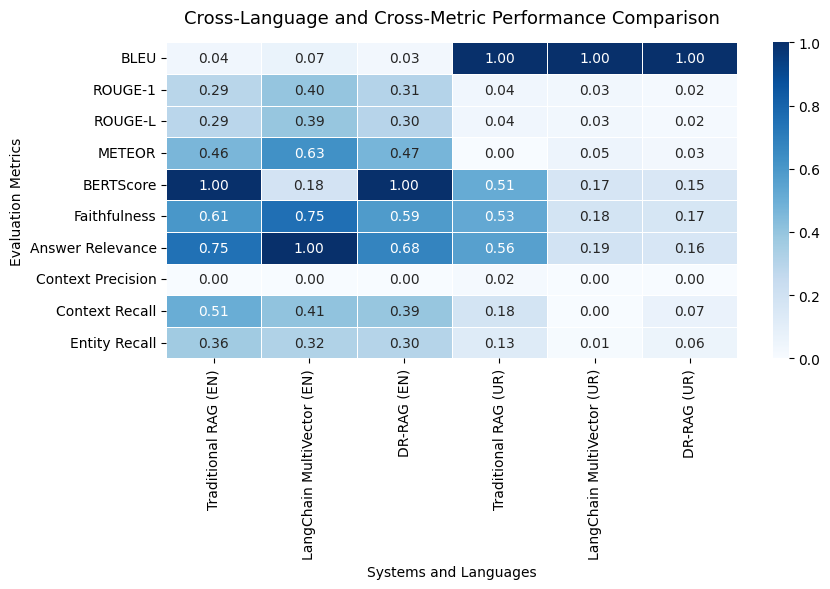

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ====================================================
# 1️⃣ Example Combined Metrics for Both Languages
# ====================================================
data = {
    'Metric': [
        'BLEU', 'ROUGE-1', 'ROUGE-L', 'METEOR', 'BERTScore',
        'Faithfulness', 'Answer Relevance', 'Context Precision', 'Context Recall', 'Entity Recall'
    ],
    'Traditional RAG (EN)': [0.069, 0.281, 0.277, 0.421, 0.863, 0.538, 0.656, 0.040, 0.456, 0.339],
    'LangChain MultiVector (EN)': [0.113, 0.326, 0.325, 0.475, 0.190, 0.557, 0.715, 0.071, 0.334, 0.275],
    'DR-RAG (EN)': [0.073, 0.300, 0.296, 0.435, 0.868, 0.529, 0.603, 0.050, 0.370, 0.297],
    'Traditional RAG (UR)': [1.542, 0.066, 0.065, 0.006, 0.796, 0.815, 0.865, 0.031, 0.288, 0.204],
    'LangChain MultiVector (UR)': [4.706, 0.157, 0.155, 0.256, 0.806, 0.848, 0.896, 0.001, 0.004, 0.045],
    'DR-RAG (UR)': [4.886, 0.158, 0.158, 0.213, 0.813, 0.876, 0.847, 0.067, 0.402, 0.333],
}

df = pd.DataFrame(data)
df.set_index('Metric', inplace=True)

# Normalize each column 0–1 for heatmap consistency
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# ====================================================
# 2️⃣ Create the Heatmap
# ====================================================
plt.figure(figsize=(9, 6))
sns.heatmap(df_norm, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f", cbar=True)
plt.title("Cross-Language and Cross-Metric Performance Comparison", fontsize=13, pad=14)
plt.xlabel("Systems and Languages")
plt.ylabel("Evaluation Metrics")
plt.tight_layout()
plt.show()
